## Brain Tumor Detection with Data Science

### Theory

A brain tumor is a growth of cells in the brain or near it. Brain tumors can happen in the brain tissue.There are many types of brain tumors. The type of brain tumor is based on the kind of cells that make up the tumor.Some types of brain tumors usually aren't cancerous. These are called noncancerous brain tumors or benign brain tumors. Some types of brain tumors usually are cancerous. These types are called brain cancers or malignant brain tumors

## Setting up libraries and data

! pip install plotly

In [1]:
import numpy as np
from tqdm import tqdm
import cv2
import os
import shutil
import itertools
import imutils
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
from plotly import tools
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16, preprocess_input
from keras import layers
from keras.models import Model, Sequential
from keras.optimizers import Adam, RMSprop
from keras.callbacks import EarlyStopping

init_notebook_mode(connected=True)
RANDOM_SEED = 123


In [18]:
# create new folders
! mkdir TRAIN
! mkdir TEST
! mkdir VAL
# ! mkdir TRAIN/YES
# ! mkdir TRAIN/NO
# ! mkdir TEST/YES
# ! mkdir TEST/NO
# ! mkdir VAL/YES
# ! mkdir VAL/NO


A subdirectory or file TRAIN already exists.
A subdirectory or file TEST already exists.
A subdirectory or file VAL already exists.
The syntax of the command is incorrect.
The syntax of the command is incorrect.
The syntax of the command is incorrect.
The syntax of the command is incorrect.
The syntax of the command is incorrect.
The syntax of the command is incorrect.


In [20]:
IMG_PATH = 'input/brain-mri-images-for-brain-tumor-detection/brain_tumor_dataset/'

# split the data by train/val/test
for CLASS in os.listdir(IMG_PATH):
    if not CLASS.startswith('.'):
        IMG_NUM = len(os.listdir(IMG_PATH + CLASS))
        for (n, FILE_NAME) in enumerate(os.listdir(IMG_PATH + CLASS)):
            img = IMG_PATH + CLASS + '/' + FILE_NAME
            if n < 5:
                shutil.copy(img, 'TEST/' + CLASS.upper() + '/' + FILE_NAME)
            elif n < 0.8*IMG_NUM:
                shutil.copy(img, 'TRAIN/'+ CLASS.upper() + '/' + FILE_NAME)
            else:
                shutil.copy(img, 'VAL/'+ CLASS.upper() + '/' + FILE_NAME)

In [21]:
def load_data(dir_path, img_size=(100,100)):
    #Load resized images as np.arrays to workspace
    X = []
    y = []
    i = 0
    labels = dict()
    for path in tqdm(sorted(os.listdir(dir_path))):
        if not path.startswith('.'):
            labels[i] = path
            for file in os.listdir(dir_path + path):
                if not file.startswith('.'):
                    img = cv2.imread(dir_path + path + '/' + file)
                    X.append(img)
                    y.append(i)
            i += 1
    X = np.array(X)
    y = np.array(y)
    print(f'{len(X)} images loaded from {dir_path} directory.')
    return X, y, labels

In [22]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (6,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    cm = np.round(cm,2)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [23]:
TRAIN_DIR = 'TRAIN/'
TEST_DIR = 'TEST/'
VAL_DIR = 'VAL/'
IMG_SIZE = (224,224)

# use predefined function to load the image data into workspace
X_train, y_train, labels = load_data(TRAIN_DIR, IMG_SIZE)
X_test, y_test, _ = load_data(TEST_DIR, IMG_SIZE)
X_val, y_val, _ = load_data(VAL_DIR, IMG_SIZE)

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.24it/s]
C:\Users\RAJ\AppData\Local\Temp\ipykernel_14036\299934090.py:16: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



193 images loaded from TRAIN/ directory.


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 65.92it/s]


10 images loaded from TEST/ directory.


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.84it/s]

50 images loaded from VAL/ directory.


In [24]:
y = dict() # Count the number of classes in each set
y[0] = []
y[1] = []
for set_name in (y_train, y_val, y_test):
    y[0].append(np.sum(set_name == 0))
    y[1].append(np.sum(set_name == 1))

trace0 = go.Bar( # Create a bar plot showing the count of classes in each set
    x=['Train Set', 'Validation Set', 'Test Set'],
    y=y[0],
    name='No',
    marker=dict(color='#33cc33'),
    opacity=0.7
)
trace1 = go.Bar(
    x=['Train Set', 'Validation Set', 'Test Set'],
    y=y[1],
    name='Yes',
    marker=dict(color='#ff3300'),
    opacity=0.7
)
data = [trace0, trace1]
layout = go.Layout(
    title='Count of classes in each set',
    xaxis={'title': 'Set'},
    yaxis={'title': 'Count'}
)
fig = go.Figure(data, layout)
iplot(fig)

In [25]:
def plot_samples(X, y, labels_dict, n=50):
    """
    Creates a gridplot for desired number of images (n) from the specified set
    """
    for index in range(len(labels_dict)):
        imgs = X[np.argwhere(y == index)][:n]
        j = 10
        i = int(n/j)

        plt.figure(figsize=(15,6))
        c = 1
        for img in imgs:
            plt.subplot(i,j,c)
            plt.imshow(img[0])

            plt.xticks([])
            plt.yticks([])
            c += 1
        plt.suptitle('Tumor: {}'.format(labels_dict[index]))
        plt.show()

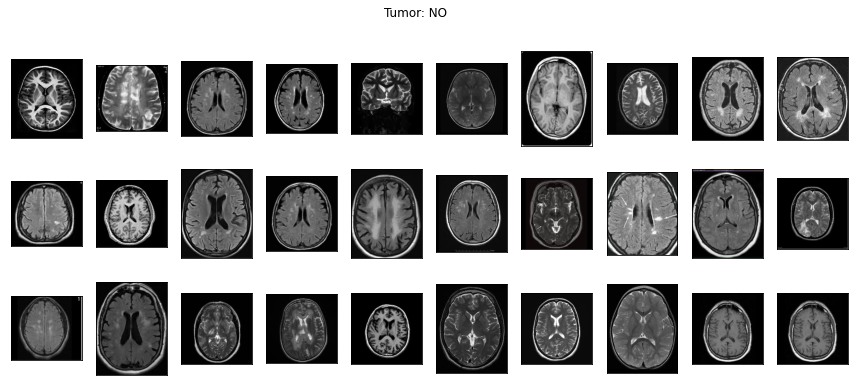

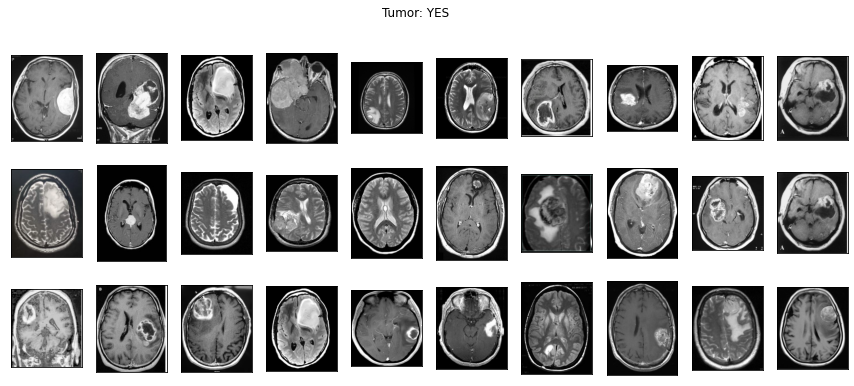

In [26]:
plot_samples(X_train, y_train, labels, 30)

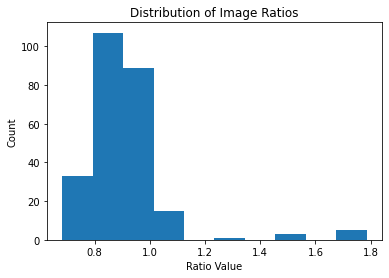

In [27]:
RATIO_LIST = [] # Calculate and plot the distribution of image ratios
for set in (X_train, X_test, X_val):
    for img in set:
        RATIO_LIST.append(img.shape[1]/img.shape[0])
        
plt.hist(RATIO_LIST)
plt.title('Distribution of Image Ratios')
plt.xlabel('Ratio Value')
plt.ylabel('Count')
plt.show()

In [28]:
def crop_imgs(set_name, add_pixels_value=0):
    """
    Finds the extreme points on the image and crops the rectangular out of them
    """
    set_new = []
    for img in set_name:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        gray = cv2.GaussianBlur(gray, (5, 5), 0)

        # threshold the image, then perform a series of erosions +
        # dilations to remove any small regions of noise
        thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
        thresh = cv2.erode(thresh, None, iterations=2)
        thresh = cv2.dilate(thresh, None, iterations=2)

        # find contours in thresholded image, then grab the largest one
        cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnts = imutils.grab_contours(cnts)
        c = max(cnts, key=cv2.contourArea)

        # find the extreme points
        extLeft = tuple(c[c[:, :, 0].argmin()][0])
        extRight = tuple(c[c[:, :, 0].argmax()][0])
        extTop = tuple(c[c[:, :, 1].argmin()][0])
        extBot = tuple(c[c[:, :, 1].argmax()][0])

        ADD_PIXELS = add_pixels_value
        new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()
        set_new.append(new_img)

    return np.array(set_new)

In [29]:
img = cv2.imread('input/brain-mri-images-for-brain-tumor-detection/brain_tumor_dataset/yes/Y108.jpg')
img = cv2.resize(
            img,
            dsize=IMG_SIZE,
            interpolation=cv2.INTER_CUBIC
        )
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
gray = cv2.GaussianBlur(gray, (5, 5), 0)

# threshold the image, then perform a series of erosions +
# dilations to remove any small regions of noise
thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
thresh = cv2.erode(thresh, None, iterations=2)
thresh = cv2.dilate(thresh, None, iterations=2)

# find contours in thresholded image, then grab the largest one
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
c = max(cnts, key=cv2.contourArea)

# find the extreme points
extLeft = tuple(c[c[:, :, 0].argmin()][0])
extRight = tuple(c[c[:, :, 0].argmax()][0])
extTop = tuple(c[c[:, :, 1].argmin()][0])
extBot = tuple(c[c[:, :, 1].argmax()][0])

# add contour on the image
img_cnt = cv2.drawContours(img.copy(), [c], -1, (0, 255, 255), 4)

# add extreme points
img_pnt = cv2.circle(img_cnt.copy(), extLeft, 8, (0, 0, 255), -1)
img_pnt = cv2.circle(img_pnt, extRight, 8, (0, 255, 0), -1)
img_pnt = cv2.circle(img_pnt, extTop, 8, (255, 0, 0), -1)
img_pnt = cv2.circle(img_pnt, extBot, 8, (255, 255, 0), -1)

# crop
ADD_PIXELS = 0
new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()

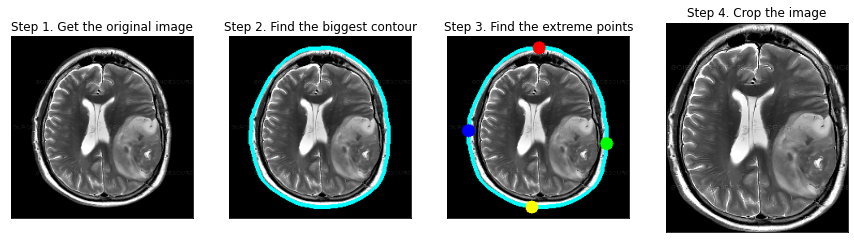

In [30]:
plt.figure(figsize=(15,6))# Plotting the intermediate steps
plt.subplot(141)
plt.imshow(img)
plt.xticks([])
plt.yticks([])
plt.title('Step 1. Get the original image')
plt.subplot(142)
plt.imshow(img_cnt)
plt.xticks([])
plt.yticks([])
plt.title('Step 2. Find the biggest contour')
plt.subplot(143)
plt.imshow(img_pnt)
plt.xticks([])
plt.yticks([])
plt.title('Step 3. Find the extreme points')
plt.subplot(144)
plt.imshow(new_img)
plt.xticks([])
plt.yticks([])
plt.title('Step 4. Crop the image')
plt.show()

In [31]:
# apply this for each set
X_train_crop = crop_imgs(set_name=X_train)
X_val_crop = crop_imgs(set_name=X_val)
X_test_crop = crop_imgs(set_name=X_test)

C:\Users\RAJ\AppData\Local\Temp\ipykernel_14036\2254567846.py:31: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



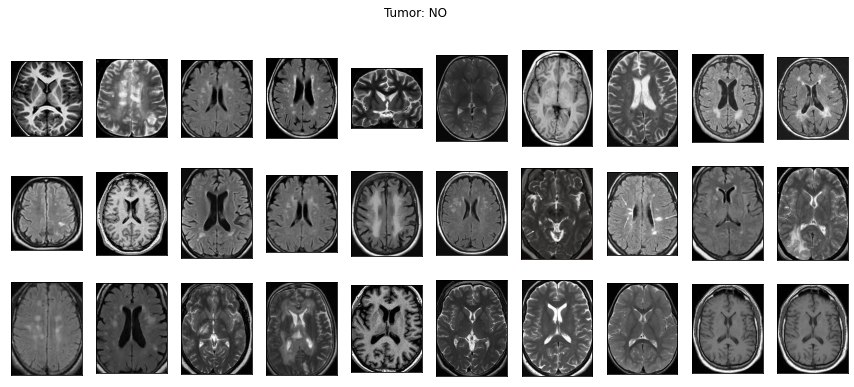

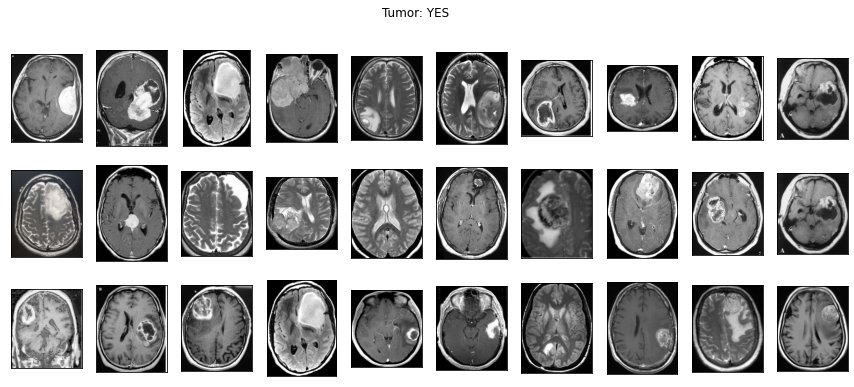

In [32]:
plot_samples(X_train_crop, y_train, labels, 30)

In [33]:
def save_new_images(x_set, y_set, folder_name):
    i = 0
    for (img, imclass) in zip(x_set, y_set):
        if imclass == 0:
            cv2.imwrite(folder_name+'NO/'+str(i)+'.jpg', img)
        else:
            cv2.imwrite(folder_name+'YES/'+str(i)+'.jpg', img)
        i += 1

In [34]:
# saving new images to the folder
os.makedirs("TRAIN_CROP/YES", exist_ok=True)
os.makedirs("TRAIN_CROP/NO", exist_ok=True)
os.makedirs("TEST_CROP/YES", exist_ok=True)
os.makedirs("TEST_CROP/NO", exist_ok=True)
os.makedirs("VAL_CROP/YES", exist_ok=True)
os.makedirs("VAL_CROP/NO", exist_ok=True)

save_new_images(X_train_crop, y_train, folder_name='TRAIN_CROP/')
save_new_images(X_val_crop, y_val, folder_name='VAL_CROP/')
save_new_images(X_test_crop, y_test, folder_name='TEST_CROP/')

In [36]:
def preprocess_imgs(set_name, img_size):
    """
    Resize and apply VGG-16 preprocessing
    """
    set_new = []
    for img in set_name:
        img = cv2.resize(
            img,
            dsize=img_size,
            interpolation=cv2.INTER_CUBIC
        )
        set_new.append(preprocess_input(img)) # Apply VGG-16 preprocessing to the resized image and add it to the list
    return np.array(set_new)# Convert the list of preprocessed images to a numpy array and return it

In [37]:
X_train_prep = preprocess_imgs(set_name=X_train_crop, img_size=IMG_SIZE)
X_test_prep = preprocess_imgs(set_name=X_test_crop, img_size=IMG_SIZE)
X_val_prep = preprocess_imgs(set_name=X_val_crop, img_size=IMG_SIZE)

In [ ]:
#plot_samples(X_train_prep, y_train, labels, 30)

In [38]:
TRAIN_DIR = 'TRAIN_CROP/'
VAL_DIR = 'VAL_CROP/'
# Create an ImageDataGenerator for training data with data augmentation
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    brightness_range=[0.5, 1.5],
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function=preprocess_input
)
# Create an ImageDataGenerator for testing data
test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

# Create a generator for training data
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    color_mode='rgb',
    target_size=IMG_SIZE,
    batch_size=32,
    class_mode='binary',
    seed=RANDOM_SEED
)

# Create a generator for validation data
validation_generator = test_datagen.flow_from_directory(
    VAL_DIR,
    color_mode='rgb',
    target_size=IMG_SIZE,
    batch_size=16,
    class_mode='binary',
    seed=RANDOM_SEED
)

Found 193 images belonging to 2 classes.
Found 50 images belonging to 2 classes.


In [39]:
# load base model
vgg16_weight_path = 'input/keras-pretrained-models/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'
base_model = VGG16(
    weights=vgg16_weight_path,
    include_top=False, 
    input_shape=IMG_SIZE + (3,)
)

In [40]:
NUM_CLASSES = 1

model = Sequential()
model.add(base_model)
model.add(layers.Flatten())
model.add(layers.Dropout(0.5)) # Add a Dropout layer to prevent overfitting by randomly setting input units to 0
model.add(layers.Dense(NUM_CLASSES, activation='sigmoid'))

model.layers[0].trainable = False
# Compile the model with binary cross-entropy loss, RMSprop optimizer, and accuracy metric
model.compile(
    loss='binary_crossentropy',
    optimizer=RMSprop(lr=1e-4),
    metrics=['accuracy']
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dropout (Dropout)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 1)                 25089     
                                                                 
Total params: 14739777 (56.23 MB)
Trainable params: 25089 (98.00 KB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


In [43]:
# Define the number of epochs and set up early stopping
EPOCHS = 30
es = EarlyStopping(
    monitor='val_accuracy', 
    mode='max',
    patience=6
)
# Train the model using the fit_generator function
history = model.fit_generator(
    train_generator,
    steps_per_epoch=len(train_generator), 
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=25,
    callbacks=[es]
)


C:\Users\RAJ\AppData\Local\Temp\ipykernel_14036\996890868.py:9: UserWarning:

`Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.



Epoch 1/30
7/7 [==============================] - ETA: 0s - loss: 4.4073 - accuracy: 0.7668WARNING:tensorflow:Early stopping conditioned on metric `val_accuracy` which is not available. Available metrics are: loss,accuracy


7/7 [==============================] - 26s 4s/step - loss: 4.4073 - accuracy: 0.7668
Epoch 2/30
7/7 [==============================] - ETA: 0s - loss: 3.3942 - accuracy: 0.7772WARNING:tensorflow:Early stopping conditioned on metric `val_accuracy` which is not available. Available metrics are: loss,accuracy


7/7 [==============================] - 25s 3s/step - loss: 3.3942 - accuracy: 0.7772
Epoch 3/30
7/7 [==============================] - ETA: 0s - loss: 2.6213 - accuracy: 0.8238WARNING:tensorflow:Early stopping conditioned on metric `val_accuracy` which is not available. Available metrics are: loss,accuracy


7/7 [==============================] - 25s 3s/step - loss: 2.6213 - accuracy: 0.8238
Epoch 4/30
7/7 [==============================] - ETA: 0s - loss: 4.3403 - accuracy: 0.7617WARNING:tensorflow:Early stopping conditioned on metric `val_accuracy` which is not available. Available metrics are: loss,accuracy


7/7 [==============================] - 26s 4s/step - loss: 4.3403 - accuracy: 0.7617
Epoch 5/30
7/7 [==============================] - ETA: 0s - loss: 2.2192 - accuracy: 0.8238WARNING:tensorflow:Early stopping conditioned on metric `val_accuracy` which is not available. Available metrics are: loss,accuracy


7/7 [==============================] - 29s 4s/step - loss: 2.2192 - accuracy: 0.8238
Epoch 6/30
7/7 [==============================] - ETA: 0s - loss: 1.5133 - accuracy: 0.8601WARNING:tensorflow:Early stopping conditioned on metric `val_accuracy` which is not available. Available metrics are: loss,accuracy


7/7 [==============================] - 27s 4s/step - loss: 1.5133 - accuracy: 0.8601
Epoch 7/30
7/7 [==============================] - ETA: 0s - loss: 2.6722 - accuracy: 0.8135WARNING:tensorflow:Early stopping conditioned on metric `val_accuracy` which is not available. Available metrics are: loss,accuracy


7/7 [==============================] - 28s 4s/step - loss: 2.6722 - accuracy: 0.8135
Epoch 8/30
7/7 [==============================] - ETA: 0s - loss: 2.5557 - accuracy: 0.8601WARNING:tensorflow:Early stopping conditioned on metric `val_accuracy` which is not available. Available metrics are: loss,accuracy


7/7 [==============================] - 27s 4s/step - loss: 2.5557 - accuracy: 0.8601
Epoch 9/30
7/7 [==============================] - ETA: 0s - loss: 2.3321 - accuracy: 0.8290WARNING:tensorflow:Early stopping conditioned on metric `val_accuracy` which is not available. Available metrics are: loss,accuracy


7/7 [==============================] - 28s 4s/step - loss: 2.3321 - accuracy: 0.8290
Epoch 10/30
7/7 [==============================] - ETA: 0s - loss: 1.6875 - accuracy: 0.8860WARNING:tensorflow:Early stopping conditioned on metric `val_accuracy` which is not available. Available metrics are: loss,accuracy


7/7 [==============================] - 27s 4s/step - loss: 1.6875 - accuracy: 0.8860
Epoch 11/30
7/7 [==============================] - ETA: 0s - loss: 1.6829 - accuracy: 0.8653WARNING:tensorflow:Early stopping conditioned on metric `val_accuracy` which is not available. Available metrics are: loss,accuracy


7/7 [==============================] - 27s 4s/step - loss: 1.6829 - accuracy: 0.8653
Epoch 12/30
7/7 [==============================] - ETA: 0s - loss: 1.6101 - accuracy: 0.8756WARNING:tensorflow:Early stopping conditioned on metric `val_accuracy` which is not available. Available metrics are: loss,accuracy


7/7 [==============================] - 26s 3s/step - loss: 1.6101 - accuracy: 0.8756
Epoch 13/30
7/7 [==============================] - ETA: 0s - loss: 3.4341 - accuracy: 0.7927WARNING:tensorflow:Early stopping conditioned on metric `val_accuracy` which is not available. Available metrics are: loss,accuracy


7/7 [==============================] - 27s 4s/step - loss: 3.4341 - accuracy: 0.7927
Epoch 14/30
7/7 [==============================] - ETA: 0s - loss: 2.2524 - accuracy: 0.8964WARNING:tensorflow:Early stopping conditioned on metric `val_accuracy` which is not available. Available metrics are: loss,accuracy


7/7 [==============================] - 27s 4s/step - loss: 2.2524 - accuracy: 0.8964
Epoch 15/30
7/7 [==============================] - ETA: 0s - loss: 1.0029 - accuracy: 0.9119WARNING:tensorflow:Early stopping conditioned on metric `val_accuracy` which is not available. Available metrics are: loss,accuracy


7/7 [==============================] - 30s 4s/step - loss: 1.0029 - accuracy: 0.9119
Epoch 16/30
7/7 [==============================] - ETA: 0s - loss: 2.6674 - accuracy: 0.8290WARNING:tensorflow:Early stopping conditioned on metric `val_accuracy` which is not available. Available metrics are: loss,accuracy


7/7 [==============================] - 28s 4s/step - loss: 2.6674 - accuracy: 0.8290
Epoch 17/30
7/7 [==============================] - ETA: 0s - loss: 1.4258 - accuracy: 0.9067WARNING:tensorflow:Early stopping conditioned on metric `val_accuracy` which is not available. Available metrics are: loss,accuracy


7/7 [==============================] - 26s 3s/step - loss: 1.4258 - accuracy: 0.9067
Epoch 18/30
7/7 [==============================] - ETA: 0s - loss: 3.3900 - accuracy: 0.8031WARNING:tensorflow:Early stopping conditioned on metric `val_accuracy` which is not available. Available metrics are: loss,accuracy


7/7 [==============================] - 26s 4s/step - loss: 3.3900 - accuracy: 0.8031
Epoch 19/30
7/7 [==============================] - ETA: 0s - loss: 2.1371 - accuracy: 0.8653WARNING:tensorflow:Early stopping conditioned on metric `val_accuracy` which is not available. Available metrics are: loss,accuracy


7/7 [==============================] - 26s 4s/step - loss: 2.1371 - accuracy: 0.8653
Epoch 20/30
7/7 [==============================] - ETA: 0s - loss: 1.3132 - accuracy: 0.9016WARNING:tensorflow:Early stopping conditioned on metric `val_accuracy` which is not available. Available metrics are: loss,accuracy


7/7 [==============================] - 28s 4s/step - loss: 1.3132 - accuracy: 0.9016
Epoch 21/30
7/7 [==============================] - ETA: 0s - loss: 1.5134 - accuracy: 0.8860WARNING:tensorflow:Early stopping conditioned on metric `val_accuracy` which is not available. Available metrics are: loss,accuracy


7/7 [==============================] - 27s 4s/step - loss: 1.5134 - accuracy: 0.8860
Epoch 22/30
7/7 [==============================] - ETA: 0s - loss: 1.2624 - accuracy: 0.9067WARNING:tensorflow:Early stopping conditioned on metric `val_accuracy` which is not available. Available metrics are: loss,accuracy


7/7 [==============================] - 27s 4s/step - loss: 1.2624 - accuracy: 0.9067
Epoch 23/30
7/7 [==============================] - ETA: 0s - loss: 1.9984 - accuracy: 0.8912WARNING:tensorflow:Early stopping conditioned on metric `val_accuracy` which is not available. Available metrics are: loss,accuracy


7/7 [==============================] - 26s 3s/step - loss: 1.9984 - accuracy: 0.8912
Epoch 24/30
7/7 [==============================] - ETA: 0s - loss: 0.8445 - accuracy: 0.9275WARNING:tensorflow:Early stopping conditioned on metric `val_accuracy` which is not available. Available metrics are: loss,accuracy


7/7 [==============================] - 24s 3s/step - loss: 0.8445 - accuracy: 0.9275
Epoch 25/30
7/7 [==============================] - ETA: 0s - loss: 1.6024 - accuracy: 0.9067WARNING:tensorflow:Early stopping conditioned on metric `val_accuracy` which is not available. Available metrics are: loss,accuracy


7/7 [==============================] - 27s 4s/step - loss: 1.6024 - accuracy: 0.9067
Epoch 26/30
7/7 [==============================] - ETA: 0s - loss: 1.0458 - accuracy: 0.9119WARNING:tensorflow:Early stopping conditioned on metric `val_accuracy` which is not available. Available metrics are: loss,accuracy


7/7 [==============================] - 27s 4s/step - loss: 1.0458 - accuracy: 0.9119
Epoch 27/30
7/7 [==============================] - ETA: 0s - loss: 2.5768 - accuracy: 0.8497WARNING:tensorflow:Early stopping conditioned on metric `val_accuracy` which is not available. Available metrics are: loss,accuracy


7/7 [==============================] - 27s 4s/step - loss: 2.5768 - accuracy: 0.8497
Epoch 28/30
7/7 [==============================] - ETA: 0s - loss: 2.1180 - accuracy: 0.8601WARNING:tensorflow:Early stopping conditioned on metric `val_accuracy` which is not available. Available metrics are: loss,accuracy


7/7 [==============================] - 27s 4s/step - loss: 2.1180 - accuracy: 0.8601
Epoch 29/30
7/7 [==============================] - ETA: 0s - loss: 0.8897 - accuracy: 0.9326WARNING:tensorflow:Early stopping conditioned on metric `val_accuracy` which is not available. Available metrics are: loss,accuracy


7/7 [==============================] - 26s 4s/step - loss: 0.8897 - accuracy: 0.9326
Epoch 30/30
7/7 [==============================] - ETA: 0s - loss: 1.2277 - accuracy: 0.9223WARNING:tensorflow:Early stopping conditioned on metric `val_accuracy` which is not available. Available metrics are: loss,accuracy


7/7 [==============================] - 26s 4s/step - loss: 1.2277 - accuracy: 0.9223


In [44]:
# plot model performance
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(history.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()

KeyError: 'val_accuracy'

In [ ]:
# validate on val set
predictions = model.predict(X_val_prep)
predictions = [1 if x>0.5 else 0 for x in predictions]

accuracy = accuracy_score(y_val, predictions)
print('Val Accuracy = %.2f' % accuracy)

confusion_mtx = confusion_matrix(y_val, predictions) 
cm = plot_confusion_matrix(confusion_mtx, classes = list(labels.items()), normalize=False)

In [ ]:
# validate on test set
predictions = model.predict(X_test_prep)
predictions = [1 if x>0.5 else 0 for x in predictions]

accuracy = accuracy_score(y_test, predictions)
print('Test Accuracy = %.2f' % accuracy)

confusion_mtx = confusion_matrix(y_test, predictions) 
cm = plot_confusion_matrix(confusion_mtx, classes = list(labels.items()), normalize=False)

In [ ]:
ind_list = np.argwhere((y_test == predictions) == False)[:, -1]
if ind_list.size == 0:
    print('There are no missclassified images.')
else:
    for i in ind_list:
        plt.figure()
        plt.imshow(X_test_crop[i])
        plt.xticks([])
        plt.yticks([])
        plt.title(f'Actual class: {y_val[i]}\nPredicted class: {predictions[i]}')
        plt.show()

In [ ]:
# clean up the space
!rm -rf TRAIN TEST VAL TRAIN_CROP TEST_CROP VAL_CROP
# save the model
model.save('2019-06-07_VGG_model.h5')